# Automatic Wetland Mapping Using Python

## Imports and setup

In [1]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson
# import gdal
from osgeo import gdal
# import ogr
from osgeo import ogr

import shapely 
import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms

## Authenticate Google Earth Engine

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qgVy0wtjh8BqRvkiRmL9vIG4SLl7S9iKnrtGZc78lXjcEZyStfl6ME



Successfully saved authorization token.


## Set Current Working Directory

In [3]:
# cwd = './drive/My Drive/Colab Notebooks/Crop Field Delineation/'
cwd = '/Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/'

## Download country boundaries

In [122]:
ISO = 'SWE' # "DEU" is the ISO code for Germany
ADM = 'ADM2' # Equivalent to administrative districts
# start_date = '2018-07-01';
# end_date = '2018-07-31';
start_date = '2018-05-01';
end_date = '2018-05-31';

# Query geoBoundaries
r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM={}".format(ISO, ADM))
dl_path = r.json()[0]['gjDownloadURL']

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()
with open(filename, 'w') as file:
    geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (290, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
258,Harryda kommun,None,SWE-ADM2-3_0_0-B259,SWE,ADM2,"MULTIPOLYGON (((12.42902 57.73086, 12.44093 57..."
177,Vimmerby kommun,None,SWE-ADM2-3_0_0-B178,SWE,ADM2,"MULTIPOLYGON (((16.30039 57.52985, 16.20860 57..."
29,Sigtuna kommun,None,SWE-ADM2-3_0_0-B30,SWE,ADM2,"MULTIPOLYGON (((18.08522 59.73841, 18.08723 59..."


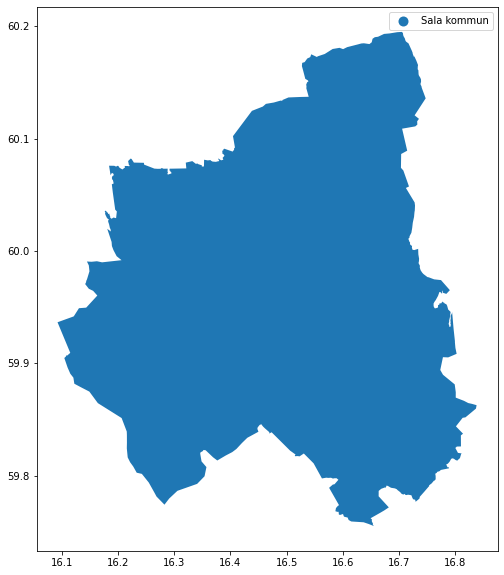

In [123]:
shape_name = 'Sala kommun'
# shape_name = 'Koping kommun'
# shape_name = 'Ljusnarsberg kommun'
# shape_name = 'Skinnskatteberg kommun'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

## Generate Sentinel-1 images

In [124]:
def generate_image(
    region, 
    product='COPERNICUS/S1', 
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the 
    Pythin Earth Engine API.
    
    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default )

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite   
    sarImage = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
        .filter(ee.Filter.eq('instrumentMode', 'IW'))\
        .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))\
        .median()\
        .clip(region)
    
    sarImage = sarImage.select(['VV'])

    percentiles = sarImage.reduceRegion(
        reducer=ee.Reducer.percentile([0, 1, 5, 50, 95, 99, 100]),
        geometry=region,
        scale=20
    )

    minValue = percentiles.get("VV_p1").getInfo()
    maxValue = percentiles.get("VV_p99").getInfo()
    
    sarImage = sarImage.visualize(bands=['VV'], min=minValue, max=maxValue)
    
    # Get RGB bands
    # image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return sarImage

We generate and visualize the Sentinel-1 satellite image for Sala kommun. The satellite image is generated by getting the median of all Sentinel-1 images in 2019 and 2020. 

In [125]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region)

# Generate SAR image using GEE
image = generate_image(
    region, 
    product='COPERNICUS/S1_GRD', # Sentinel-1
    min_date=start_date,
    max_date=end_date,
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel1')
Map.addLayerControl()
Map

## Export image to local GDrive

In [91]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.
    
    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of 
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))
        
    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()
    
    return task

We can now proceed to download the image to our local Google Drive as a GeoTIFF.

In [129]:
# folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
# task = export_image(image, shape_name + '-sar-' + start_date, region, folder)

In [143]:
task.status()

{'state': 'COMPLETED',
 'description': 'Sala kommun2018-05-01-sar',
 'creation_timestamp_ms': 1660839015791,
 'update_timestamp_ms': 1660839700753,
 'start_timestamp_ms': 1660839027187,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1jX4-3iUNKUNV5BkQOlJ37yLJ4tIkg09j'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 211.30938720703125,
 'id': '6XAGEUHWTRLYTGWE4KFEMZDO',
 'name': 'projects/earthengine-legacy/operations/6XAGEUHWTRLYTGWE4KFEMZDO'}

## Instantiate U-Net model

In [99]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super().__init__()

        self.encoder1 = self.block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.block(features, features*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.block(features*2, features*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.block(features*4, features*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.block(features*8, features*16)

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = self.block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.block(features*2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))

        return torch.sigmoid(self.conv(dec1))

    def block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

## Load trained model

In [100]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
    print("GPU: {}".format(torch.cuda.get_device_name(0)))

model_dir = cwd + "models/"
model_file = model_dir + 'best_model_20220809.pth'

model = Unet(in_channels=1)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()
model = model.to(device)

print('Model file {} successfully loaded.'.format(model_file))

Device: mps
Model file /Users/frape/Projects/DeepWetlands/src/deep-wetlands/external/data/models/best_model_20220809.pth successfully loaded.


## Model Prediction

### Load Sentinel-1 satellite image

In [101]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def load_image(dir_path):
#     image_bands = []
#     for band in range(1, 4):
#         array = rio.open(dir_path).read(band)
#         array[np.isnan(array)] = 0
#         image_bands.append(normalize(array))

#     image = np.dstack(image_bands)
    image = rio.open(dir_path).read(1)
    image = normalize(image)
    return image

### Visualize Sentinel-1 imagery

<class 'numpy.ndarray'> (4897, 8297)
[0.60392157 0.60392157 0.61176471 ... 0.         0.         0.        ]


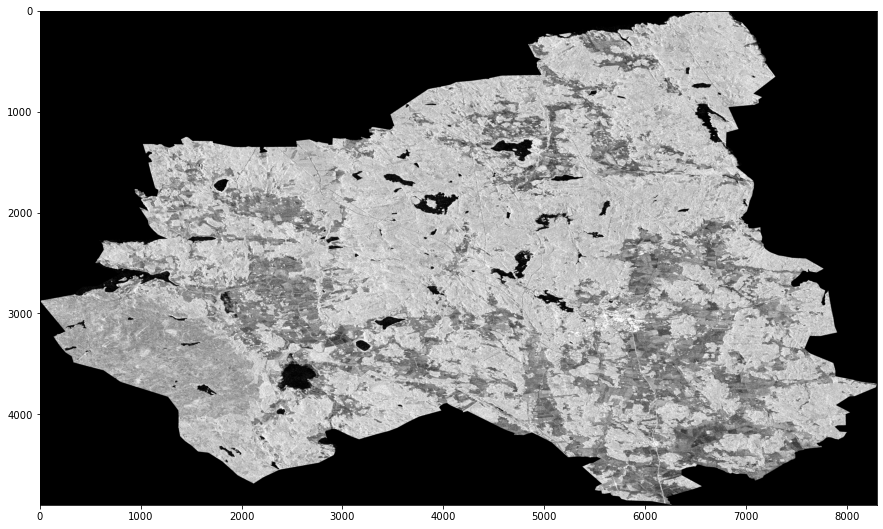

In [144]:
# shape_name = 'Sala kommun'
tif_file = cwd + '{}-sar-{}.tif'.format(shape_name, start_date) 
image = load_image(tif_file)

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(image, cmap='gray')
print(type(image), image.shape)
print(image[2000, 2000:])

### Visualize cropped 64x64 image

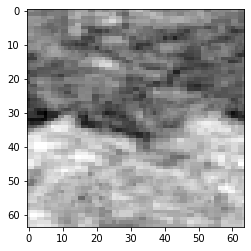

In [145]:
image_size = 64
w_start = image_size*25
h_start = image_size*88

image_crop = image[
    w_start:w_start+image_size, 
    h_start:h_start+image_size,
    # :
]

# Plot image 
plt.imshow(image_crop, cmap='gray');

### Visualize model prediction on a single cropped image

In [146]:
# # image_crop = torch.from_numpy(
# #     (image_crop * 255.0).astype("uint8").transpose((2, 1, 0)).astype(np.float32)
# # ).to(device)[None, :]
# image_crop = image_crop[None, :][None, :]
# image_crop = torch.from_numpy(image_crop.astype(np.float32)).to(device)
# print(type(image_crop), image_crop.shape)
# pred = model(image_crop).cpu().detach().numpy()
# pred = pred.squeeze()
# pred = np.where(pred < 0.5, 1, 0)
# plt.imshow(pred.transpose((1,0)));
# plt.imshow(pred)

torch.Size([1, 1, 64, 64])


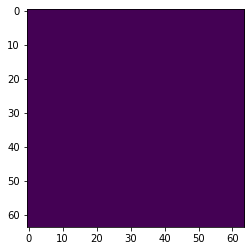

In [147]:
# image = image.transpose((2, 1, 0))[None, :]
image_crop = image_crop[None, :][None, :]
image_crop = torch.from_numpy(image_crop.astype(np.float32)).to(device)
print(image_crop.shape)
pred = model(image_crop).cpu().detach().numpy()
# pred = pred.squeeze().transpose((1, 0))
pred = pred.squeeze()
pred = np.where(pred < 0.5, 0, 1)
# pred = (pred * 255.0).astype("uint8")
plt.imshow(pred)

In [148]:
print(next(model.parameters()).device)
print(type(image_crop), image_crop.shape)
print(image_crop)

mps:0
<class 'torch.Tensor'> torch.Size([1, 1, 64, 64])
tensor([[[[0.6863, 0.6863, 0.6392,  ..., 0.6980, 0.6275, 0.6275],
          [0.6275, 0.6275, 0.6235,  ..., 0.6196, 0.5882, 0.5882],
          [0.7098, 0.7098, 0.7098,  ..., 0.6196, 0.5804, 0.5804],
          ...,
          [0.8549, 0.9569, 0.9569,  ..., 0.7804, 0.7804, 0.7961],
          [0.8745, 0.8902, 0.8902,  ..., 0.8196, 0.8196, 0.8627],
          [0.8706, 0.9137, 0.9137,  ..., 0.8392, 0.8392, 0.8706]]]],
       device='mps:0')


### Putting it all together

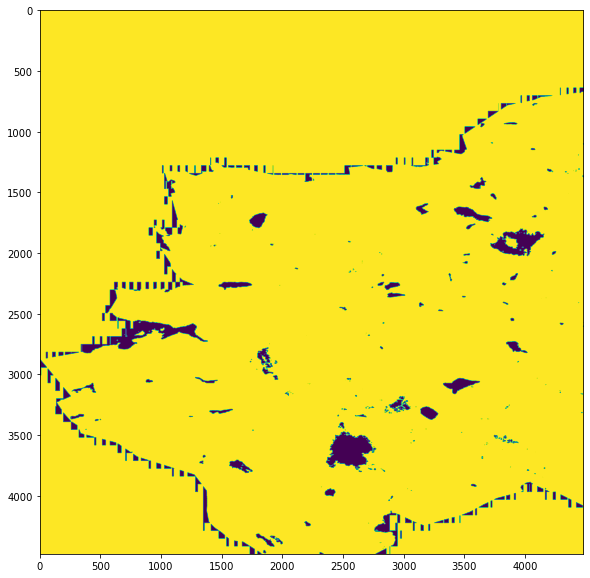

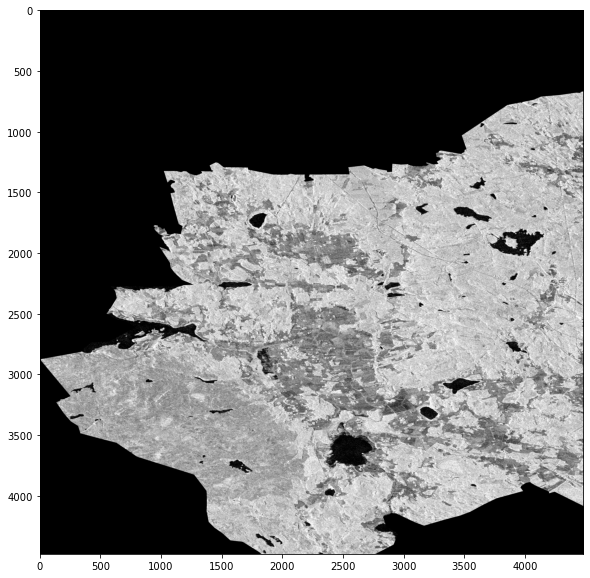

In [150]:
n, step_size = 70, 64
width, height = step_size*n, step_size*n
pred_mask = np.zeros(tuple((width, height)))

for h in range(0, height, step_size):
    for w in range(0, width, step_size):
        image_crop = image[w:w+step_size, h:h+step_size]
        image_crop = image_crop[None, :]
        binary_image = np.where(image_crop.sum(2) > 0, 1, 0)

        # image_crop = torch.from_numpy(
        #     (image_crop * 255.0).astype("uint8").transpose((2, 1, 0)).astype(np.float32)
        # ).to(device)[None, :]
        image_crop = torch.from_numpy(image_crop.astype(np.float32)).to(device)[None, :]

        pred = model(image_crop).cpu().detach().numpy()
        pred = (pred).squeeze()*binary_image
        pred = np.where(pred < 0.5, 0, 1)
        pred_mask[w:w+step_size, h:h+step_size] = pred
    
fig, ax = plt.subplots(figsize=(10, 10)) 
pred_mask = 1 - pred_mask
plt.imshow(pred_mask)
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(image[:width, :height], cmap='gray');

## Post-processing output

### Generating georeference raster image

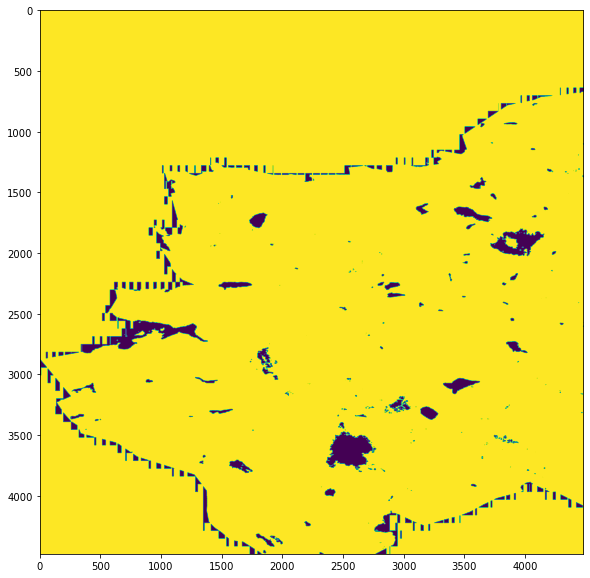

In [151]:
from rasterio.windows import Window
def generate_raster(image, src_tif, dest_file):
    with rio.open(src_tif) as src:
        # Create a Window and calculate the transform from the source dataset    
        window = Window(0, 0, width, height)
        transform = src.window_transform(window)

        out_meta = src.meta
        out_meta.update({
            "driver": "GTiff",
            "height": height,
            "width": width,
            "count": 1,
            "transform": src.transform
        })
        with rio.open(dest_file, "w", **out_meta) as dest:
            dest.write(image.astype(rio.uint8), 1)

pred_file = cwd + 'temp.tif'
generate_raster(pred_mask, src_tif=tif_file, dest_file=pred_file)
mask = rio.open(pred_file)

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(10,10)) 
plt.imshow(mask.read(1));

### Polygonize rasters

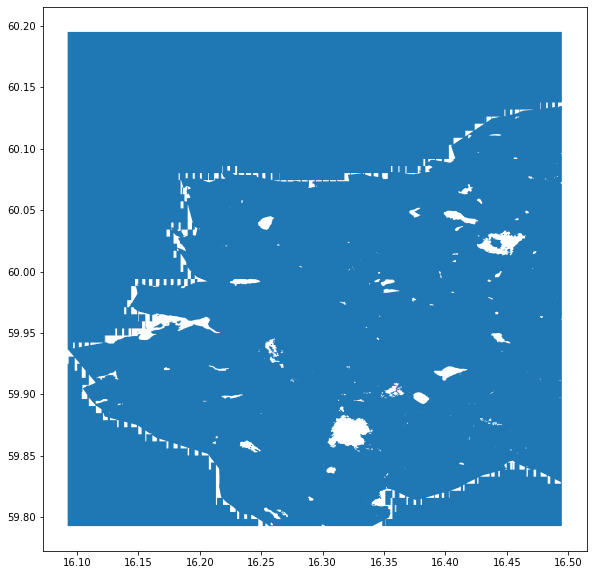

In [152]:
def polygonize_raster(src_raster_file, dest_file, tolerance=0.00005):
    src_raster = gdal.Open(src_raster_file)
    band = src_raster.GetRasterBand(1)
    band_array = band.ReadAsArray()
    driver = ogr.GetDriverByName("ESRI Shapefile")
    out_data_src = driver.CreateDataSource(dest_file)
    out_layer = out_data_src.CreateLayer("polygonized", srs=None)
    gdal.Polygonize(band, band, out_layer, -1, [], callback=None)
    out_data_src.Destroy()
    polygons = gpd.read_file(dest_file).simplify(tolerance)
    polygons.to_file(dest_file)

out_shape_file = cwd+"{}_polygonized_{}.shp".format(shape_name, start_date)
polygonize_raster(pred_file, out_shape_file)
polygons = gpd.read_file(out_shape_file)
polygons.plot(figsize=(10, 10));

## Visualize using Folium

In [154]:
polygons_file = cwd+"/{}_polygonized_{}.shp".format(shape_name, start_date)
polygons = gpd.read_file(polygons_file)

centroid = polygons.dissolve().centroid
map = folium.Map(location=[centroid.y.iloc[0], centroid.x.iloc[0]], zoom_start=11)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add polygons
for _, r in polygons.iterrows():
    geo_series = gpd.GeoSeries(r['geometry'])
    geo_json = geo_series.to_json()
    geo_json = folium.GeoJson(
        data=geo_json, 
        style_function=lambda feature: {'fillOpacity' : 0.}
    )
    geo_json.add_to(map)

map